# Synthetic spike train data

Here we visualize our synthetic dataset.

### Table of contents

1. [**Generating synthetic animal behaviour**](#behav)
2. [**Creating place cell tuning curves**](#tuning)
3. [**Generating rate-rescaled renewal process spike trains**](#gen)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt


import pickle

import animal
import synthetic

import sys

sys.path.append("../../")
import lib


/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/data/synthetic/animal.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)

seed = 123  # seed for random numbers

prng_state = jr.PRNGKey(seed)

<a id='behav'></a>
## 1. Generating synthetic animal behaviour

We simulated an animal exploring in a 2D box arena

In [5]:
track_samples = 1000000
arena = animal.get_arena('box')

sample_bin = 0.02 # s
track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t = generate.generate_data(
    arena, 'Lever', sample_bin, track_samples, seed)

  0%|          | 0/999999 [00:00<?, ?it/s]

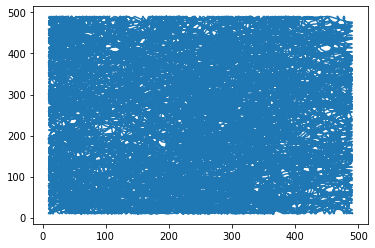

In [6]:
pos_t = np.stack([x_t, y_t], axis=-1)

plt.plot(x_t, y_t)
plt.show()

<a id='tuning'></a>
## 2. Creating place field tuning curves

In [8]:
mdl = generate.model('Gaussian')
ratefunc, N = mdl.get_model()

# rates
xlist = [np.linspace(0, 500, 100), np.linspace(0, 500, 100)]
x_dims = len(xlist)

xx = np.meshgrid(*xlist)
xx = jnp.stack(xx, axis=-1)

or_shape = xx.shape[:-1]
xx = xx.reshape(-1, x_dims)  # (evals, x_dim)

rates = jax.vmap(ratefunc)(xx)
rates = rates.reshape(*or_shape, -1)

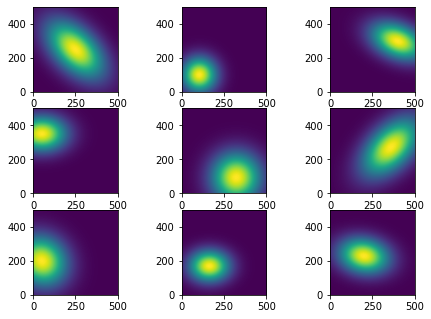

In [9]:
fig = plt.figure(figsize=(6, 4))

widths = [1] * 3
heights = [1] * 3
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1.0, bottom=0.0, 
                        left=0.0, right=1., wspace=0.1)

for n in range(3):
    for m in range(3):
        k = 3*n + m
        ax = fig.add_subplot(spec[n, m])

        ax.imshow(rates[..., k], extent=[xlist[0][0], xlist[0][-1], xlist[1][0], xlist[1][-1]], origin='lower', cmap='viridis')
        ax.set_xlim([xlist[0][0], xlist[0][-1]])
        ax.set_ylim([xlist[1][0], xlist[1][-1]])
        
        
plt.show()

<a id='gen'></a>
## 3. Generating rate-rescaled renewal process spike trains

In [11]:
obs_dims = N
dt = 0.001
ts = pos_t.shape[0]

ini_t_step = jnp.zeros(obs_dims)
rates_t = jax.vmap(ratefunc)(pos_t)

In [12]:
S = 3

spikes, prms = [], {}
for en, rtype in enumerate(['gamma', 'lognorm', 'invgauss']):
    prng_state, prng_key = jr.split(prng_state)
    rm, prms[rtype] = generate.get_renewal(rtype, S, dt)
    spikes.append(
        lib.likelihoods.distributions.sample_rate_rescaled_renewal(
            prng_key, rm.sample_ISI, ini_t_step[S*en:S*(en+1)], 
            rates_t[:, S*en:S*(en+1)].T, dt
        )
    )
    
spikes = np.concatenate(spikes, axis=-1)

# ISI
ISI_orders = 5
ISIs = lib.utils.spikes.get_lagged_ISIs(spikes, ISI_orders, dt)
ISIs = np.array(ISIs)  # (ts, N, orders)

In [13]:
spikes.sum(0)

array([3367., 2387., 2096., 2121., 6833., 6721., 6835., 2161., 1556.])

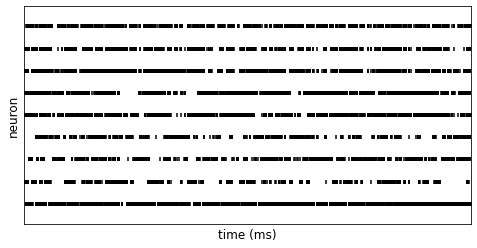

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
fig.set_facecolor('white')

lib.utils.plots.raster_plot((fig, ax), spikes[:, :].T, ts, dt*1000, obs_dims, markersize=10)
lib.utils.plots.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

plt.show()

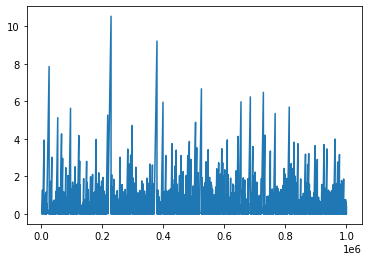

In [15]:
plt.plot(ISIs[:, 0, 0])

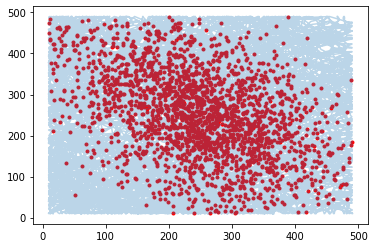

In [216]:
n, tr = 0, 2

plt.plot(x_t, y_t, alpha=0.3)
plt.scatter(x_t[spikes[tr, n, :].astype(bool)], y_t[spikes[tr, n, :].astype(bool)], marker='.', c='r')
plt.show()